<a href="https://colab.research.google.com/github/minghsu0107/ML/blob/master/machine-learning/titanic_predict3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Settings

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
sns.set(font_scale=1.56)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
# loading data
df_train = pd.read_csv('./drive/My Drive/titanic/train.csv')
df_test = pd.read_csv('./drive/My Drive/titanic/test.csv')
df_data = df_train.append(df_test)
# for display dataframe
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
# ignore warning
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## Sex and Pclass

,Sex,Survived
0,female,0.742
1,male,0.189


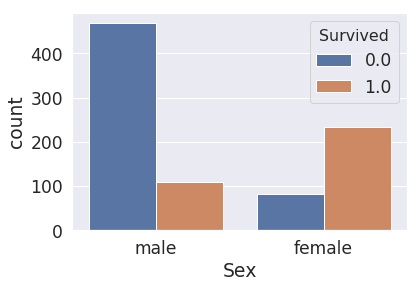

In [18]:
display(df_data[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean().round(3))
sns.countplot(df_data['Sex'], hue=df_data['Survived'])

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


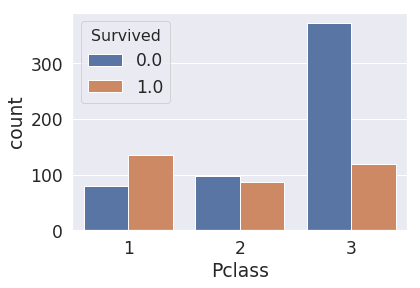

In [110]:
sns.countplot(df_data['Pclass'], hue=df_data['Survived'])
df_data[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().round(3)

In [0]:
# Convert Sex
df_data['Sex_Code'] = df_data['Sex'].map({'female' : 1, 'male' : 0}).astype('int')


# split training set the testing set
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

# Inputs set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

## Base Line

In [21]:
# Show Baseline
Base = ['Sex_Code','Pclass']
Base_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
Base_Model.fit(X[Base], Y)
print('Base oob score :%.5f' %(Base_Model.oob_score_))

Base oob score :0.73176


In [0]:
# submission if you want
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

Base_pred = Base_Model.predict(X_Submit[Base])

submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                      "Survived":Base_pred.astype(int)})
submit.to_csv("submit_Base.csv",index=False)

## Fare

由於票價分布非常廣及傾斜，有非常高的票價也有非常低的，我們將票價取log來畫圖會好看一點。(註 : 取log之後同時也可以解決傾斜的問題，若是在Regression Problem中也是必要的預處理)

Fare        
Survived    0.0     1.0
Pclass                 
1         44.75  77.958
2         13.00  21.000
3          8.05   8.517

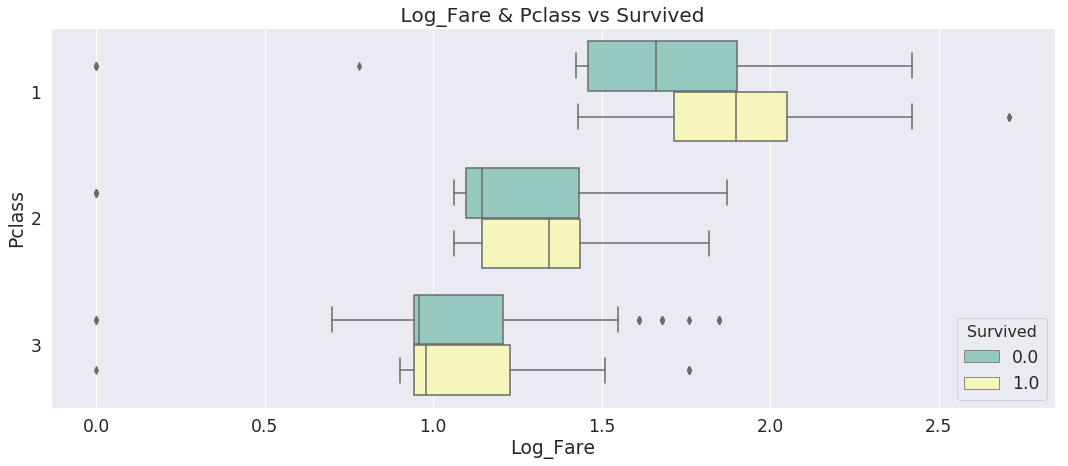

In [24]:
# there is some bugs in log-scale of boxplot. 
# alternatively, we transform x into log10(x) for visualization.
fig, ax = plt.subplots( figsize = (18,7) )
df_data['Log_Fare'] = (df_data['Fare']+1).map(lambda x : np.log10(x) if x > 0 else 0)
sns.boxplot(y='Pclass', x='Log_Fare',hue='Survived',data=df_data, orient='h'
                ,ax=ax,palette="Set3")
ax.set_title(' Log_Fare & Pclass vs Survived ',fontsize = 20)

pd.pivot_table(df_data,values = ['Fare'], index = ['Pclass'], columns= ['Survived'] ,aggfunc = 'median' ).round(3)

Pclass,1,2,3
FareBin_Code_4,,,
0,8,6,323
1,0,128,193
2,77,104,147
3,238,39,46
Pclass,1,2,3
FareBin_Code_5,,,
0,8,6,261
1,0,36,218
2,0,124,132


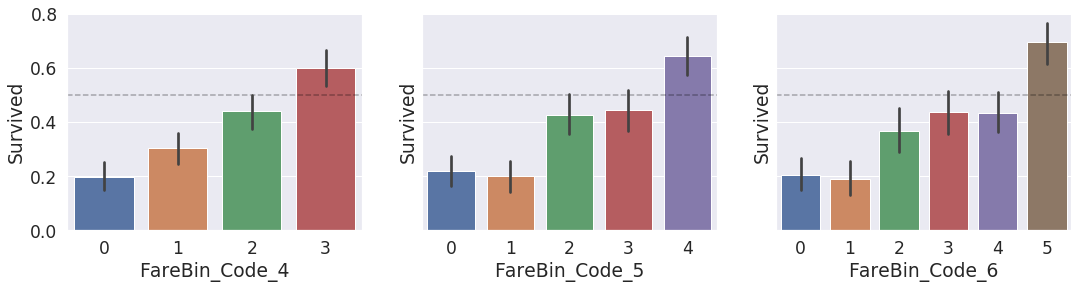

In [212]:
# Filling missing values
df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())

# Making Bins
df_data['FareBin_4'] = pd.qcut(df_data['Fare'], 4)
df_data['FareBin_5'] = pd.qcut(df_data['Fare'], 5)
df_data['FareBin_6'] = pd.qcut(df_data['Fare'], 6)

label = LabelEncoder()
df_data['FareBin_Code_4'] = label.fit_transform(df_data['FareBin_4'])
df_data['FareBin_Code_5'] = label.fit_transform(df_data['FareBin_5'])
df_data['FareBin_Code_6'] = label.fit_transform(df_data['FareBin_6'])

# cross tab
df_4 = pd.crosstab(df_data['FareBin_Code_4'],df_data['Pclass'])
df_5 = pd.crosstab(df_data['FareBin_Code_5'],df_data['Pclass'])
df_6 = pd.crosstab(df_data['FareBin_Code_6'],df_data['Pclass'])

display_side_by_side(df_4,df_5,df_6)

# plots
fig, [ax1, ax2, ax3] = plt.subplots(1, 3,sharey=True)
fig.set_figwidth(18)
for axi in [ax1, ax2, ax3]:
    axi.axhline(0.5,linestyle='dashed', c='black',alpha = .3)
g1 = sns.factorplot(x='FareBin_Code_4', y="Survived", data=df_data,kind='bar',ax=ax1)
g2 = sns.factorplot(x='FareBin_Code_5', y="Survived", data=df_data,kind='bar',ax=ax2)
g3 = sns.factorplot(x='FareBin_Code_6', y="Survived", data=df_data,kind='bar',ax=ax3)
# close FacetGrid object
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)

圖中虛線表示為機器隨機亂猜，應該要有50%的準確率，如果我們的特徵工程沒辦法將各區間分離開50%，那就沒什麼意義。

In [45]:
# splits again beacuse we just engineered new feature
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']
# show columns
X.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Ticket', 'Sex_Code', 'Log_Fare', 'FareBin_4', 'FareBin_5',
       'FareBin_6', 'FareBin_Code_4', 'FareBin_Code_5', 'FareBin_Code_6'],
      dtype='object')

利用前向選擇法(RFE)做特徵選擇，關於特徵選擇的方法我們有幾個選項，一是用單變數的Chi square、或是information gain，但RFE可以考慮到特徵之間的交互作用，缺點是需要較大的運算資源，這點由於我們的資料集比較少而可以獲得緩解

The size of grid_scores_ is equal to ceil((n_features - min_features_to_select) / step) + 1, where step is the number of features removed at each iteration.

In [53]:
compare = ['Sex_Code','Pclass','FareBin_Code_4','FareBin_Code_5','FareBin_Code_6']
selector = RFECV(RandomForestClassifier(n_estimators=250,min_samples_split=20),cv=10,n_jobs=-1)
# selector.fit_transform(X[compare], Y)
selector.fit(X[compare], Y)
selector.transform(X[compare])

print(selector.estimator_)
print(selector.n_features_)
print(selector.support_)
print(selector.ranking_)
print(selector.grid_scores_*100) # cv scores of each feature "subset"

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
5
[ True  True  True  True  True]
[1 1 1 1 1]
[78.66981614 77.33398593 79.34774713 79.24293497 80.25544774]


In [0]:
score_b4,score_b5, score_b6 = [], [], []
seeds = 10
for i in range(seeds):
    diff_cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=i)
    selector = RFECV(RandomForestClassifier(random_state=i,n_estimators=250,min_samples_split=20),cv=diff_cv,n_jobs=-1)
    selector.fit(X[compare], Y)
    score_b4.append(selector.grid_scores_[2])
    score_b5.append(selector.grid_scores_[3])
    score_b6.append(selector.grid_scores_[4])

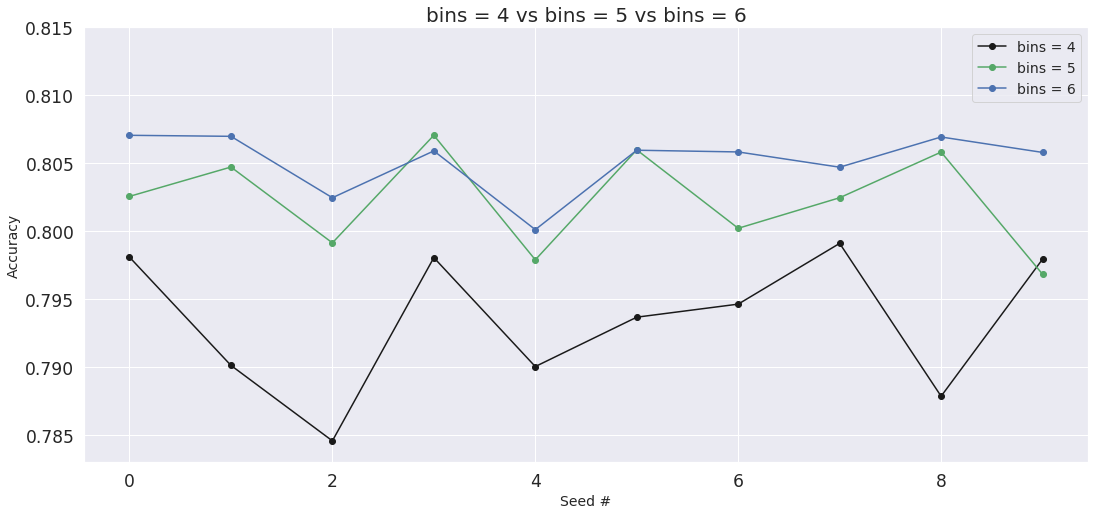

In [50]:
# to np.array
score_list = [score_b4, score_b5, score_b6]
for item in score_list:
    item = np.array(item*100)

# plot
fig = plt.figure(figsize= (18,8) )
ax = plt.gca()
ax.plot(range(seeds), score_b4,'-ok',label='bins = 4')
ax.plot(range(seeds), score_b5,'-og',label='bins = 5')
ax.plot(range(seeds), score_b6,'-ob',label='bins = 6')
ax.set_xlabel("Seed #", fontsize = '14')
ax.set_ylim(0.783,0.815)
ax.set_ylabel("Accuracy", fontsize = '14')
ax.set_title('bins = 4 vs bins = 5 vs bins = 6', fontsize='20')
plt.legend(fontsize = 14,loc='upper right')

In [48]:
b4, b5, b6 = ['Sex_Code', 'Pclass','FareBin_Code_4'], ['Sex_Code','Pclass','FareBin_Code_5'],\
['Sex_Code','Pclass','FareBin_Code_6']
b4_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b4_Model.fit(X[b4], Y)
b5_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b5_Model.fit(X[b5], Y)
b6_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b6_Model.fit(X[b6], Y)
print('b4 oob score :%.5f' %(b4_Model.oob_score_),'   LB_Public : 0.7790')
print('b5 oob score :%.5f '%(b5_Model.oob_score_),' LB_Public : 0.79425')
print('b6 oob score : %.5f' %(b6_Model.oob_score_), '  LB_Public : 0.77033')

b4 oob score :0.80584    LB_Public : 0.7790
b5 oob score :0.81033   LB_Public : 0.79425
b6 oob score : 0.80135   LB_Public : 0.77033


## Connected Survival

發現了乘客持有相同的船票意味著他們可能是家人或是朋友，而在訓練集上這些互相有連結的人常常是一起活下來或是一起喪命

In [56]:
df_train['Ticket'].describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

In [0]:
# Family_size
df_data['Family_size'] = df_data['SibSp'] + df_data['Parch'] + 1

In [61]:
deplicate_ticket = []
for tk in df_data.Ticket.unique():
    tem = df_data.loc[df_data.Ticket == tk, 'Fare']
    #print(tem.count())
    if tem.count() > 1:
        #print(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare']])
        deplicate_ticket.append(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare','Cabin','Family_size','Survived']])
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(14)

,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
234,"Cumings, Mr. John Bradley",PC 17599,71.2833,C85,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
146,"Hilliard, Mr. Herbert Henry",17463,51.8625,E46,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


In [62]:
df_fri = deplicate_ticket.loc[(deplicate_ticket.Family_size == 1) & (deplicate_ticket.Survived.notnull())].head(7)
df_fami = deplicate_ticket.loc[(deplicate_ticket.Family_size > 1) & (deplicate_ticket.Survived.notnull())].head(7)
display(df_fri,df_fami)
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print('friends: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size == 1]))
print('families: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size > 1]))

,Name,Ticket,Fare,Cabin,Family_size,Survived
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
20,"Fynney, Mr. Joseph J",239865,26.0000,NaN,1,0.0
791,"Gaskell, Mr. Alfred",239865,26.0000,NaN,1,0.0
195,"Lurette, Miss. Elise",PC 17569,146.5208,B80,1,1.0
681,"Hassab, Mr. Hammad",PC 17572,76.7292,D49,1,1.0
61,"Icard, Miss. Amelie",113572,80.0000,B28,1,1.0
829,"Stone, Mrs. George Nelson (Martha Evelyn)",113572,80.0000,B28,1,1.0


,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


people keep the same ticket: 596 
friends: 127 
families: 469 


In [76]:
# the same ticket family or friends
df_data['Connected_Survival'] = 0.5 # default 
for _, df_grp in df_data.groupby('Ticket'):
    if (len(df_grp) > 1):
        for idx, row in df_grp.iterrows():
            smax = df_grp.drop(idx)['Survived'].max()
            smin = df_grp.drop(idx)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print("people have connected information : %.0f" 
      %(df_data[df_data['Connected_Survival']!=0.5].shape[0]))
df_data.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


In [77]:
for a, b in df_data.groupby('Ticket'):
    pass
print(a) # index
print(b)

WE/P 5735
      Age Cabin Embarked  ...  FareBin_Code_6 Family_size  Connected_Survival
540  36.0   B22        S  ...               5           3                 0.0
745  70.0   B22        S  ...               5           3                 1.0

[2 rows x 22 columns]


In [78]:
for p, q in b.iterrows():
    print(p) # index
    print(q)

540
Age                                        36
Cabin                                     B22
Embarked                                    S
Fare                                       71
Name                  Crosby, Miss. Harriet R
Parch                                       2
PassengerId                               541
Pclass                                      1
Sex                                    female
SibSp                                       0
Survived                                    1
Ticket                              WE/P 5735
Sex_Code                                    1
Log_Fare                              1.85733
FareBin_4                   (31.275, 512.329]
FareBin_5                   (41.579, 512.329]
FareBin_6                     (53.1, 512.329]
FareBin_Code_4                              3
FareBin_Code_5                              4
FareBin_Code_6                              5
Family_size                                 3
Connected_Survival            

In [0]:
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [108]:
connect = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival']
connect_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20
                                       ,oob_score=True)
connect_Model.fit(X[connect], Y)
print('connect oob score :%.5f' %(connect_Model.oob_score_))

connect oob score :0.82043


## Age

Sex,female,male,All
Has_Age,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


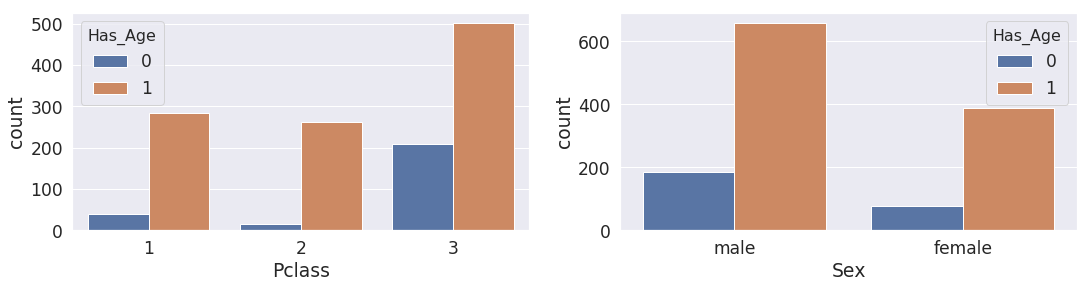

In [113]:
df_data['Has_Age'] = df_data['Age'].isnull().map(lambda x : 0 if x == True else 1)
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.set_figwidth(18)
ax1 = sns.countplot(df_data['Pclass'],hue=df_data['Has_Age'],ax=ax1)
ax2 = sns.countplot(df_data['Sex'],hue=df_data['Has_Age'],ax=ax2)
pd.crosstab(df_data['Has_Age'],df_data['Sex'],margins=True)

1,2艙之中，年齡對存活與否的影響:

Text(0.5, 1.0, 'Age vs Survived in Pclass = 1 and  2')

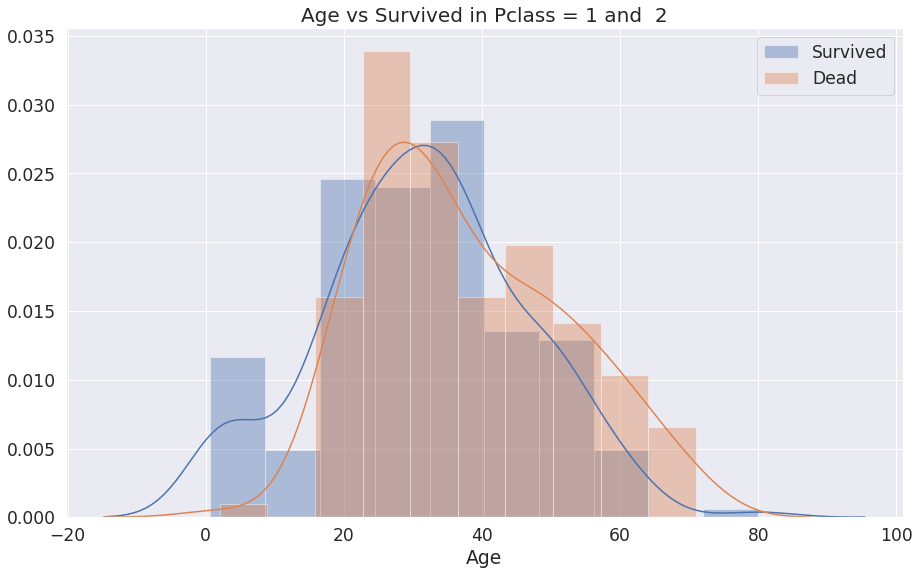

In [115]:
# Masks
Mask_Has_Age_P12_Survived = ( (df_data.Has_Age == 1) & (df_data.Pclass != 3 ) & (df_data.Survived == 1) )
Mask_Has_Age_P12_Dead = ( (df_data.Has_Age == 1) & (df_data.Pclass != 3 ) & (df_data.Survived == 0) )
# Plot
fig, ax = plt.subplots( figsize = (15,9) )
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Survived, 'Age'],kde=True,bins=10,norm_hist=True,label='Survived') 
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Dead, 'Age'],kde=True,bins=10,norm_hist=True,label='Dead')
ax.legend()
ax.set_title('Age vs Survived in Pclass = 1 and  2',fontsize = 20)

In [185]:
# extracted title using name
df_data['Title'] = df_data.Name.str.extract('([A-Za-z]+)\.', expand=False)
df_data['Title'] = df_data['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Rare') 
df_data['Title'] = df_data['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
df_data['Title'] = df_data['Title'].replace(['Lady'],'Mrs')
df_data['Title'] = df_data['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })
Ti = df_data.groupby('Title')['Age'].median()
Ti

Title
0    29.0
1    47.0
2     4.0
3    22.0
4    36.0
Name: Age, dtype: float64

In [200]:
df_data.Name.str.extract('([A-Za-z]+\.)', expand=False).head()

0      Mr.
1     Mrs.
2    Miss.
3     Mrs.
4      Mr.
Name: Name, dtype: object

In [201]:
df_data.Name.str.extract('([A-Za-z]+)\.', expand=False).head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Name, dtype: object

In [0]:
Ti_pred = df_data.groupby('Title')['Age'].median().values
df_data['Ti_Age'] = df_data['Age']
# Filling the missing age
for i in range(0,5):
    df_data.loc[(df_data.Age.isnull()) & (df_data.Title == i),'Ti_Age'] = Ti_pred[i]
df_data['Ti_Age'] = df_data['Ti_Age'].astype('int')
df_data['Ti_Minor'] = ((df_data['Ti_Age']) < 16.0) * 1

In [0]:
# splits again beacuse we just engineered new feature
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [170]:
minor = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival','Ti_Minor']
minor_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
minor_Model.fit(X[minor], Y)
print('minor oob score :%.5f' %(minor_Model.oob_score_))

minor oob score :0.84175


### LightGBM

In [0]:
from bayes_opt import BayesianOptimization
import warnings
warnings.simplefilter('ignore')
train_x, test_x, train_y, test_y = train_test_split(X[minor], 
                                                    Y, 
                                                    test_size=0.2, 
                                                    random_state=0)

In [0]:
import lightgbm as lgb

N_FOLDS = 10
train_set = lgb.Dataset(train_x, label = train_y)

def gbm_cv(max_depth, num_leaves, learning_rate, subsample_for_bin, min_child_samples, 
           reg_alpha, reg_lambda, subsample, colsample_bytree, n_folds = N_FOLDS):
    
    params = {'max_depth': int(max_depth), 
              'num_leaves': int(num_leaves),
              'learning_rate': learning_rate,
              'subsample_for_bin': int(subsample_for_bin),
              'min_child_samples': int(min_child_samples),
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree}
    
    #交叉驗證 early_stopping_rounds是指超過100次都沒有改善的話就會停止模型
    cv_results = lgb.cv(params, train_set, num_boost_round=10000, nfold=n_folds,
                        stratified=False, shuffle=True, metrics='auc',
                        early_stopping_rounds=100, verbose_eval=False, show_stdv=True)
    
    
    score = np.max(cv_results['auc-mean'])
    
    return score

In [171]:
gbm_bo = BayesianOptimization(
        gbm_cv,
        {'max_depth': (3, 15), 
        'num_leaves': (20, 100),
        'learning_rate': (0.01, 0.3),
        'subsample_for_bin': (100000, 300000),
        'min_child_samples': (10, 100),
        'reg_alpha': (0.1, 1.0),
        'reg_lambda': (0.1, 1.0),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.5, 1.0)})
# defualt: choose 5 samples initially, then iterate for 25 times(30 times in total)
gbm_bo.maximize(n_iter=3)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8835   |  0.7825   |  0.2265   |  9.036    |  74.99    |  56.11    |  0.7549   |  0.2682   |  0.5019   |  2.047e+0 |
|  2        |  0.8867   |  0.8148   |  0.224    |  5.335    |  11.42    |  52.86    |  0.2921   |  0.1425   |  0.714    |  2.865e+0 |
|  3        |  0.8893   |  0.7675   |  0.1495   |  4.309    |  20.11    |  88.24    |  0.2372   |  0.633    |  0.5317   |  2.487e+0 |
|  4        |  0.888    |  0.8431   |  0.1836   |  9.61     |  70.37    |  38.33    |  0.2867   |  0.1257   |  0.6419   |  1.246e+0 |
|  5        |  0.8866   |  0.9474   |  0.08352  |  6.462    |  38.35    |  46.05    |  0.247    |  0.1325   |  0.7417   |  2.968e+0 |
|  6        |  0.8825   |  0.9857   |  0.2937   |  9.231    | 

In [172]:
params = gbm_bo.max['params']
params

{'colsample_bytree': 0.7675164541748616,
 'learning_rate': 0.14948546242666377,
 'max_depth': 4.309105362417211,
 'min_child_samples': 20.108180625503767,
 'num_leaves': 88.24091483609647,
 'reg_alpha': 0.2371693484086277,
 'reg_lambda': 0.633033747234419,
 'subsample': 0.5317451319128909,
 'subsample_for_bin': 248702.58627727826}

In [173]:
params['max_depth'] = int(params['max_depth'])
params['min_child_samples'] = int(params['min_child_samples'])
params['num_leaves'] = int(params['num_leaves'])
params['subsample_for_bin'] = int(params['subsample_for_bin'])
params

{'colsample_bytree': 0.7675164541748616,
 'learning_rate': 0.14948546242666377,
 'max_depth': 4,
 'min_child_samples': 20,
 'num_leaves': 88,
 'reg_alpha': 0.2371693484086277,
 'reg_lambda': 0.633033747234419,
 'subsample': 0.5317451319128909,
 'subsample_for_bin': 248702}

In [0]:
cv_res = lgb.cv(params, train_set, num_boost_round=10000, nfold=N_FOLDS,
                        stratified=False, shuffle=True, metrics='auc',
                        early_stopping_rounds=100, verbose_eval=False, show_stdv=True)

In [175]:
num_estimators = int(np.argmax(cv_res['auc-mean']) + 1)
clf = lgb.LGBMClassifier(n_estimators=num_estimators, n_jobs = -1, 
                                      objective = 'binary', random_state = 50)
clf.set_params(**params)
clf.fit(train_x, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.7675164541748616, importance_type='split',
               learning_rate=0.14948546242666377, max_depth=4,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=70, n_jobs=-1, num_leaves=88, objective='binary',
               random_state=50, reg_alpha=0.2371693484086277,
               reg_lambda=0.633033747234419, silent=True,
               subsample=0.5317451319128909, subsample_for_bin=248702,
               subsample_freq=0)

In [176]:
predict_y = clf.predict(test_x)

from sklearn.metrics import accuracy_score
print ("Accuracy = %.2f" % (accuracy_score(test_y, predict_y)))

from sklearn.metrics import roc_auc_score
print ("AUC - ROC : ", roc_auc_score(test_y, predict_y))

from sklearn import metrics
model_score = clf.score(test_x, test_y)
print ("Model Score %.2f \n" % (model_score))

confusion_matrix = metrics.confusion_matrix(test_y, predict_y)
print ("Confusion Matrix ")
print (confusion_matrix)

print ("          Predicted")
print ("         |  0  |  1  |")
print ("         |-----|-----|")
print ("       0 | %3d | %3d |" % (confusion_matrix[0, 0],
                                   confusion_matrix[0, 1]))
print ("Actual   |-----|-----|")
print ("       1 | %3d | %3d |" % (confusion_matrix[1, 0],
                                   confusion_matrix[1, 1]))
print ("         |-----|-----|")

Accuracy = 0.82
AUC - ROC :  0.7986824769433466
Model Score 0.82 

Confusion Matrix 
[[96 14]
 [19 50]]
          Predicted
         |  0  |  1  |
         |-----|-----|
       0 |  96 |  14 |
Actual   |-----|-----|
       1 |  19 |  50 |
         |-----|-----|


## Famiy Size

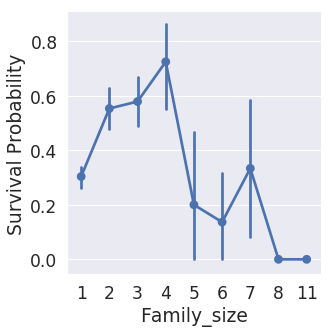

In [210]:
g = sns.factorplot(x='Family_size', y='Survived',data=df_data, kind='point')
g = g.set_ylabels("Survival Probability")

In [219]:
# cut into 3 class
df_data['L_Family'] = df_data['Family_size'].apply(lambda x: 0 if x <= 4 else 1).astype(int)

df_data.loc[ df_data['Family_size'] == 1, 'FamilyClass'] = 0
df_data.loc[ (df_data['Family_size'] <= 4) & (df_data['Family_size'] > 1), 'FamilyClass'] = 1
df_data.loc[ df_data['Family_size'] >= 5, 'FamilyClass'] = 2
df_data['FamilyClass'] = df_data['FamilyClass'].astype(int) 
print(df_data[['FamilyClass','Survived']].groupby(['FamilyClass']).mean())
pd.crosstab(df_data['FamilyClass'], df_data['Survived'])

             Survived
FamilyClass          
0            0.303538
1            0.578767
2            0.161290


Survived,0.0,1.0
FamilyClass,,
0,374,163
1,123,169
2,52,10


Family_size,1,2,3,4,5,6,7,8,11,All
Sex,,,,,,,,,,
female,194,123,79,29,14,10,9,3,5,466
male,596,112,80,14,8,15,7,5,6,843
All,790,235,159,43,22,25,16,8,11,1309


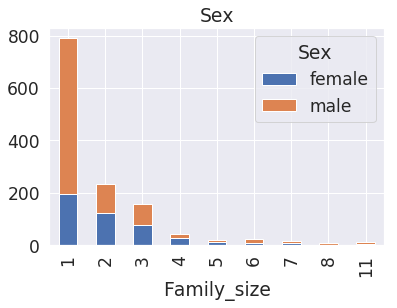

In [220]:
display(pd.crosstab(df_data['Sex'],df_data['Family_size'], margins=True))
# visualize
pd.crosstab(df_data['Family_size'],df_data['Sex']).plot(kind='bar',stacked=True,title="Sex")

我們看家庭人數=1，真的是因為獨自一人沒有受到幫助而導致較低的生存率嗎? 有可能，但是不見得，上表中我們可以清楚看到家庭人數=1之中有接近將近75%的男性，男性的生存率本來就低

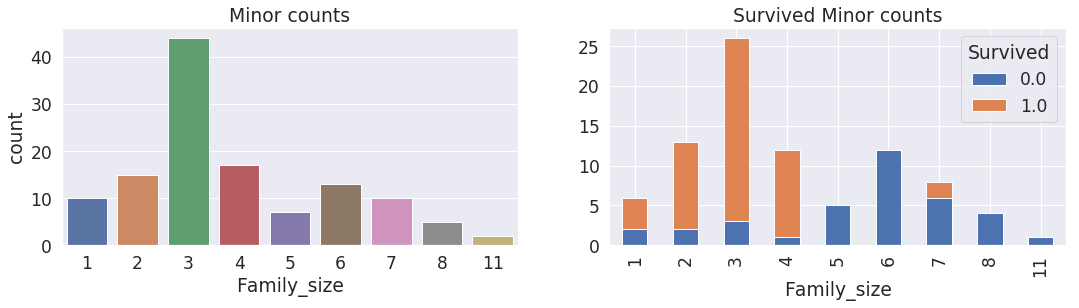

In [221]:
Minor_mask = (df_data.Ti_Minor == 1)
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.set_figwidth(18)
sns.countplot(df_data[Minor_mask]['Family_size'],ax=ax1)
ax1.set_title("Minor counts")
pd.crosstab(df_data[Minor_mask]['Family_size'],df_data[Minor_mask]['Survived'])\
.plot(kind='bar',stacked=True,title="Survived Minor counts",ax=ax2)

在家庭人數=2,3,4中，除了小孩的個數較高之外，存活的比例也非常高，這意味著家庭人數=2~4人的生存率較高很有可能僅僅是小孩存活的多，這已經涵蓋在Minor的特徵當中!
至於剩下的 Family_size >5人呢? 從分析中並沒有看出和其他特徵相關的影子，但如果我們僅是猜測其生還率低的原因是因為找不到其他家人猶豫而降低了生還率，這個理由我們在連結(Connected_Survival)已經做過同樣的推測，若僅是因為這個理由多造一個特徵，那確確實實又是冗餘了!